In [0]:
# from tqdm import tqdm
import pandas as pd
import networkx as nx
import numpy as np
from random import shuffle
import pickle

In [0]:
!pip install torch-scatter
!pip install torch-sparse
!pip install torch-cluster
!pip install torch-geometric

  Created wheel for torch-scatter: filename=torch_scatter-1.3.2-cp36-cp36m-linux_x86_64.whl size=2723704 sha256=4c1c1bd477f90eca8bc5c2d854a1c95d57411c8826bbc818b81356ee50f0fad9
  Stored in directory: /root/.cache/pip/wheels/40/30/07/5400c1a1ec05c5d0d6459fb2179d0e12c7c2f6d3d47987bf10
Successfully built torch-scatter
  Created wheel for torch-sparse: filename=torch_sparse-0.4.3-cp36-cp36m-linux_x86_64.whl size=3553921 sha256=3b622244267aa1116f8b94ad23e00a7d386bcf879e39444e67b7bcada57a0438
  Stored in directory: /root/.cache/pip/wheels/02/66/2b/befece01c2516f9fb3e7b4d150bb2b871221c73657c9cd7735
Successfully built torch-sparse
  Created wheel for torch-cluster: filename=torch_cluster-1.4.5-cp36-cp36m-linux_x86_64.whl size=14447197 sha256=6df947030a3955309de04a1080ee21159b95ff7442e8626405d81fe52f90db1c
  Stored in directory: /root/.cache/pip/wheels/0a/26/7e/a6d6a80eae5ca39b92bc77773f36cf433d5085de18014382b1
Successfully built torch-cluster
     |████████████████████████████████| 133kB 2.5MB

In [0]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, NNConv
import torch.nn as nn
import matplotlib.pyplot as plt

In [0]:
sing = pd.read_csv('singleton.csv')
pair = pd.read_csv('pair.csv')
trip = pd.read_csv('triplet.csv')

## Inspection

In [0]:
with open('embeddings', 'rb') as handle:
    edge_vals = pickle.load(handle)

In [0]:
#create edgeindex
G = nx.Graph()
first = []
sec = []
edge_feats = []
for i in range(7):
    for j in range(7):
        if i != j:
            first.append(i)
            sec.append(j)
            G.add_edge(i,j)
            edge_feats.append(edge_vals['(%d, %d)' % (i,j)])
edgeindex = [first, sec]

## Visualization

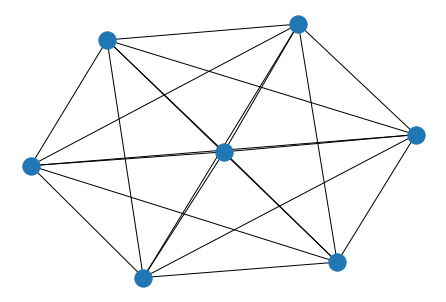

In [0]:
#Check graph

fig = nx.draw(G)
plt.show()

# Create Graph

In [0]:
sing = sing.drop(columns=['TableInfo'])
pair = pair.drop(columns=['TableInfo'])
trip = trip.drop(columns=['TableInfo'])

#For Singletons
singvals = sing.values.tolist()
pairvals = pair.values.tolist()
tripvals = trip.values.tolist()

In [0]:
torch.cuda.is_available()

True

In [0]:
data_list = []

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

#For Singletons
for i in singvals:
    node_features = torch.tensor(np.c_[i[:-1]], dtype=torch.float)
    edge_index = torch.tensor(edgeindex, dtype=torch.long)
    x = node_features
    y = torch.ones(x.shape[0], 1) * np.c_[i[-1]].ravel()[0]
    edge_features = torch.tensor(np.c_[edge_feats], dtype=torch.float)
    data = Data(x=x, edge_index=edge_index,edge_attr = edge_features, y=y).to(device)
    data_list.append(data)

for i in pairvals:
    node_features = torch.tensor(np.c_[i[:-1]], dtype=torch.float)
    edge_index = torch.tensor(edgeindex, dtype=torch.long)
    x = node_features
    y = torch.ones(x.shape[0], 1) * np.c_[i[-1]].ravel()[0]
    edge_features = torch.tensor(np.c_[edge_feats], dtype=torch.float)
    data = Data(x=x, edge_index=edge_index,edge_attr = edge_features, y=y).to(device)
    data_list.append(data)

for i in tripvals:
    node_features = torch.tensor(np.c_[i[:-1]], dtype=torch.float)
    edge_index = torch.tensor(edgeindex, dtype=torch.long)
    x = node_features
    y = torch.ones(x.shape[0], 1) * np.c_[i[-1]].ravel()[0]
    edge_features = torch.tensor(np.c_[edge_feats], dtype=torch.float)
    data = Data(x=x, edge_index=edge_index,edge_attr = edge_features, y=y).to(device)
    data_list.append(data)

In [0]:
#Split into Training, Test and Val

#Shuffle data
shuffle(data_list)

one_tenth_length = int(len(data_list) * 0.1)
train_dataset = data_list[:one_tenth_length * 8]
val_dataset = data_list[one_tenth_length*8:one_tenth_length * 9]
test_dataset = data_list[one_tenth_length*9:]
len(train_dataset), len(val_dataset), len(test_dataset)

(2336, 292, 292)

In [0]:
batch_size= 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [0]:
# ECConv convolutional network
class Net(torch.nn.Module):
    def __init__(self, input_dim, output_dim, edge_dim):
        super(Net, self).__init__()
        
        in_channel = 10
        out_channel = 10
        edge_nn_channel = 10
        edge_features = edge_dim
        
        self.input_layer = torch.nn.Sequential(
            torch.nn.Linear(input_dim, in_channel),
            torch.nn.ELU()
        )
        
        # edge condition network #1
        self.nn1 = torch.nn.Sequential(
            torch.nn.Linear(edge_features, edge_nn_channel),
            torch.nn.ELU(),
            torch.nn.Linear(edge_nn_channel, in_channel * out_channel),
            torch.nn.Tanh()
        )
        
        # edge condition network #2
        self.nn2 = torch.nn.Sequential(
            torch.nn.Linear(edge_features, edge_nn_channel),
            torch.nn.ELU(),
            torch.nn.Linear(edge_nn_channel, out_channel * out_channel),
            torch.nn.Tanh()
        )
        
        self.conv1 = NNConv(in_channel, out_channel, self.nn1, aggr='mean')
        self.conv2 = NNConv(out_channel, out_channel, self.nn2, aggr='mean')
        
        self.act1 = torch.nn.ELU()
        self.act2 = torch.nn.ELU()
        
        self.output_layer = torch.nn.Sequential(
            torch.nn.Linear(out_channel, output_dim)
        )
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        x = self.input_layer(x)
        
        x = self.conv1(x, edge_index, edge_attr)
        x = self.act1(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = self.act2(x)
        
        x = self.output_layer(x)
        return x

In [0]:
model = Net(1, 1, 1).to(device)
optimizer = torch.optim.Adamax(model.parameters())

In [0]:
# To disable tracking losses, please delete this line
loss_list = []

# model.train()
print("Epochs")

for epoch in range(5000):
    losses = list()

    for data in train_loader:
        # Forward pass
        out = model(data)
        loss = F.mse_loss(out, data.y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(
            loss.cpu().detach().numpy()
        )
        
    avg_loss = sum(losses)/len(losses)
    loss_list.append(avg_loss)
    if epoch % 500 == 0:
        print('%d, MSE loss = %f' % (epoch, avg_loss))
        
print('Training Complete')

Epochs
0, MSE loss = 0.067110
500, MSE loss = 0.011632
1000, MSE loss = 0.008764
1500, MSE loss = 0.007277
2000, MSE loss = 0.006585
2500, MSE loss = 0.006133
3000, MSE loss = 0.005706
3500, MSE loss = 0.005385
4000, MSE loss = 0.005254
4500, MSE loss = 0.004953
Training Complete


In [0]:
pred = []
test_val = []
for item in data_list:
    pred.append(model(item).detach().cpu().numpy()[0][0])
    test_val.append(item.y.detach().cpu().numpy()[0][0])
predictions = np.array(pred)
testvals = np.array(test_val)

In [0]:
predictions.shape

(152,)

In [0]:
mse = np.mean((predictions - testvals) ** 2)
print('Test MSE = ', mse)

Test MSE =  0.004431463


In [0]:
from sklearn.metrics import r2_score
r2_score(testvals,predictions)

0.9127961203674305

In [0]:
import seaborn as sns

y_all = pd.DataFrame({
    'pred': predictions,
    'true': testvals
})

y_all = y_all.sort_values(by=['true']).reset_index()[['pred', 'true']]

In [0]:
sns.lineplot(data=y_all)
plt.legend()
plt.show()

NameError: ignored